In [1]:
% cd /home/mayu-ot/durga/Experiments/loc_iparaphrasing/

/home/mayu-ot/durga/Experiments/loc_iparaphrasing


In [2]:
from chainercv.links import FasterRCNNVGG16
from chainercv.datasets import voc_bbox_label_names
from chainercv.visualizations import vis_bbox
import chainer
import chainer.links as L
import chainer.functions as F
import numpy as np
import imageio
import json
import pandas as pd
import tables
from chainer.dataset.convert import concat_examples

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
import sys
sys.path.append('script/training/')

from train import get_dataset, iParaphraseNetROISupWTL, iParaphraseNetROISupGTP

In [36]:
chainer.config.multiproc = False
model_type = 'gtp'
dataset, cvrt = get_dataset('test', mode=model_type)
roi_data = tables.open_file('data/region_feat/cca/roi_test.h5')
gt_roi_data = pd.read_csv('data/gt_roi_cord_test.csv')

test
./data/phrase_pair_test.csv
use single process data provider


,Unnamed: 0,image,org_phrase,phrase,xmax,xmin,ymax,ymin
0,0,1016887272,Several climbers,several+climbers,231,194,454,370
1,1,1016887272,Several climbers,several+climbers,256,208,384,304
2,2,1016887272,Several climbers,several+climbers,227,188,307,239
3,3,1016887272,Several climbers,several+climbers,205,165,261,205
4,4,1016887272,Several climbers,several+climbers,229,177,215,164
5,5,1016887272,Several climbers,several+climbers,209,167,184,133
6,6,1016887272,Several climbers,several+climbers,204,162,146,102


In [37]:
if model_type in ['wtl', 'wtl-gt']:
    model = iParaphraseNetROISupWTL()
else:
    model = iParaphraseNetROISupGTP()
    
chainer.serializers.load_npz('checkpoints/gtp_20180220-121725/model', model)

In [99]:
chainer.config.train = False
i = np.random.randint(len(dataset))
region_feats, phr1_feats, phr2_feats, region_label1, region_label2, l = dataset[i]

gt_w1 = region_label1
gt_w2 = region_label2

img_id = dataset._image_id[i]
phrase1 = dataset._phrase1[i]
phrase2 = dataset._phrase2[i]

roi = roi_data.get_node('/', str(dataset._image_id[i])).read()

pred = []
score = []
for phr, r_label in zip([phr1_feats, phr2_feats], [region_label1, region_label2]):
    att, _ = model.attention_net(phr[None, :], region_feats[None, :], np.asarray([0]))
    
    pred.append(roi[att.data.argmax()][[1,0,3,2]])
    score.append(att.data.max())
    
    
gt_roi1 = gt_roi_data[(gt_roi_data.image == img_id) & (gt_roi_data.phrase == phrase1)].loc[:, [ 'ymin', 'xmin', 'ymax', 'xmax']]
gt_roi2 = gt_roi_data[(gt_roi_data.image == img_id) & (gt_roi_data.phrase == phrase2)].loc[:, [ 'ymin', 'xmin', 'ymax', 'xmax']]
gt_roi1 = np.asarray(gt_roi1)
gt_roi2 = np.asarray(gt_roi2)

gt_bbox = np.vstack([gt_roi1, gt_roi2])
gt_label = [0]*len(gt_roi1)+[1]*len(gt_roi2)

(-0.5, 499.5, 332.5, -0.5)

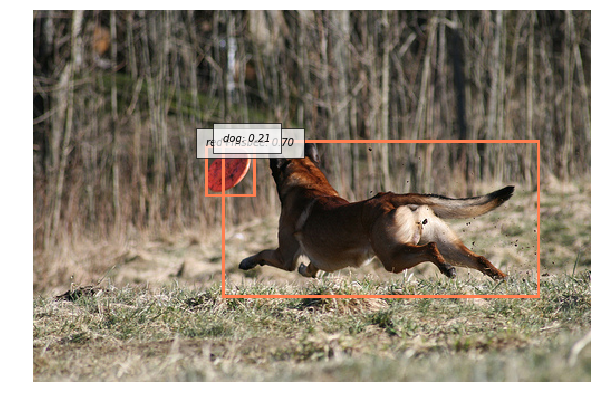

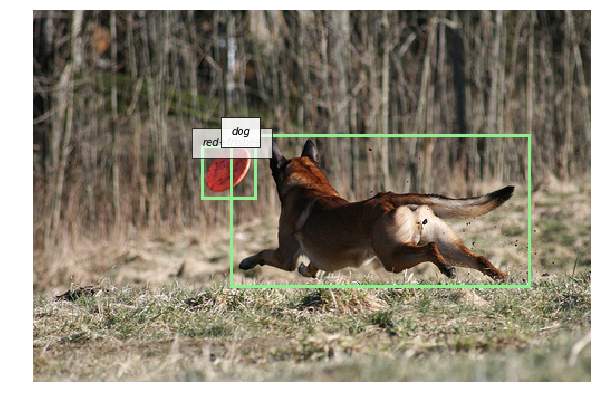

In [104]:
img = imageio.imread('/home/mayu-ot/Data/Dataset/Flickr30kEntities/flickr30k-images/%i.jpg' % img_id)
h, w, _ = img.shape
plt.close('all')
plt.figure(figsize=(10, 10))
vis_bbox(img.transpose(2,0,1), pred, [0, 1], score=score,label_names=[phrase1, phrase2], colors=['coral']*2, ax=plt.gca())
plt.axis('off')
plt.savefig('figures/grounding_%i.png'%img_id, bbox_inches='tight')

# show gt bbox
plt.figure(figsize=(10, 10))
vis_bbox(img.transpose(2,0,1), gt_bbox, gt_label,label_names=[phrase1, phrase2], colors=['lightgreen']*len(gt_label), ax=plt.gca())
plt.axis('off')

In [51]:
from chainercv.visualizations.vis_image import vis_image


def vis_bbox(img, bbox, label=None, score=None, label_names=None, colors=None, ax=None):
    from matplotlib import pyplot as plot

    if label is not None and not len(bbox) == len(label):
        raise ValueError('The length of label must be same as that of bbox')
    if score is not None and not len(bbox) == len(score):
        raise ValueError('The length of score must be same as that of bbox')

    # Returns newly instantiated matplotlib.axes.Axes object if ax is None
    ax = vis_image(img, ax=ax)

    # If there is no bounding box to display, visualize the image and exit.
    if len(bbox) == 0:
        return ax

    for i, bb in enumerate(bbox):
        xy = (bb[1], bb[0])
        height = bb[2] - bb[0]
        width = bb[3] - bb[1]
        
        c = 'red' if colors is None else colors[i]
        
        ax.add_patch(plot.Rectangle(
            xy, width, height, fill=False, edgecolor=c, linewidth=3))

        caption = list()

        if label is not None and label_names is not None:
            lb = label[i]
            if not (0 <= lb < len(label_names)):
                raise ValueError('No corresponding name is given')
            caption.append(label_names[lb])
        if score is not None:
            sc = score[i]
            caption.append('{:.2f}'.format(sc))

        if len(caption) > 0:
            ax.text(bb[1], bb[0],
                    ': '.join(caption),
                    style='italic',
                    bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10})
    return ax
